In [1]:
import json
from collections import Counter
import pandas as pd
from nltk.corpus import names
import nltk
import re 
import os
import difflib 
import logging
import itertools
from nltk.util import ngrams 
from difflib import SequenceMatcher
from string import punctuation
from termcolor import colored
from IPython.display import clear_output
%matplotlib inline

In [5]:
# Load the data. 
with open('txt/middlemarch.json') as f: 
    rawCriticism = f.readlines()

# Parse the data. 
data = [json.loads(line) for line in rawCriticism]

# Load Middlemarch
with open('middlemarch.txt') as f: 
    rawMM = f.read()

In [6]:
class Text: 
    def __init__(self, raw_text, label, removeStopwords=True): 
        if type(raw_text) == list: 
            # JSTOR critical works come in lists, where each item represents a page. 
            self.text = ' \n '.join(raw_text)
        else: 
            self.text = raw_text
        self.label = label
        self.tokens = self.getTokens(removeStopwords)
        self.trigrams = self.ngrams(3)
        
    def getTokens(self, removeStopwords=True): 
        """ Tokenizes the text, breaking it up into words, removing punctuation. """
        tokenizer = nltk.RegexpTokenizer('[a-zA-Z]\w+\'?\w*') # A custom regex tokenizer. 
        #tokenizer = nltk.RegexpTokenizer('\w+|\$[\d\.]+|\S+') # A custom regex tokenizer. 
        spans = list(tokenizer.span_tokenize(self.text))
        # Take note of how many spans there are in the text
        #print(spans)
        self.length = spans[-1][-1] 
        tokens = tokenizer.tokenize(self.text)
        tokens = [ token.lower() for token in tokens ] # make them lowercase
        if not removeStopwords: 
            self.spans = spans
            return tokens
        tokenSpans = list(zip(tokens, spans)) # zip it up
        stopwords = nltk.corpus.stopwords.words('english') # get stopwords
        tokenSpans = [ token for token in tokenSpans if token[0] not in stopwords ] # remove stopwords from zip
        self.spans = [ x[1] for x in tokenSpans ] # unzip; get spans
        return [ x[0] for x in tokenSpans ] # unzip; get tokens
    
    def ngrams(self, n): 
        """ Returns ngrams for the text."""
        return list(ngrams(self.tokens, n))

class Matcher: 
    def __init__(self, textObjA, textObjB, threshold=5, ngramSize=3, removeStopwords=True):
        """
        Takes as input two Text() objects, and matches between them.
        """
        self.threshold = threshold
        self.ngramSize = ngramSize
        
        #self.textA, self.textB = Text(fileA, removeStopwords=removeStopwords), \
        #        Text(fileB, removeStopwords=removeStopwords)
        self.textA = textObjA
        self.textB = textObjB 
        
        self.textAgrams = self.textA.ngrams(ngramSize)
        self.textBgrams = self.textB.ngrams(ngramSize)

        self.locationsA = []
        self.locationsB = []

    def getContext(self, text, start, length, context): 
        match = self.getTokensText(text, start, length)
        before = self.getTokensText(text, start-context, context)
        after = self.getTokensText(text, start+length, context)
        match = colored(match, 'red')
        out = " ".join([before, match, after])
        out = out.replace('\n', ' ') # Replace newlines with spaces. 
        out = re.sub('\s+', ' ', out)
        return out

    def getTokensText(self, text, start, length):  
        """ Looks up the passage in the original text, using its spans. """
        matchTokens = text.tokens[start:start+length]
        spans = text.spans[start:start+length]
        if len(spans) == 0: 
            # Don't try to get text or context beyond the end of a text. 
            passage = ""
        else: 
            passage = text.text[spans[0][0]:spans[-1][-1]]
        return passage 

    def getLocations(self, text, start, length, asPercentages=False): 
        """ Gets the numeric locations of the match. """
        spans = text.spans[start:start+length]
        if asPercentages: 
            locations = (spans[0][0]/text.length, spans[-1][-1]/text.length)
        else: 
            locations = (spans[0][0], spans[-1][-1])
        return locations

    def getMatch(self, match, textA, textB, context): 
        length = match.size + self.ngramSize - 1 # offset according to nGram size 
        wordsA = self.getContext(textA, match.a, length, context)
        wordsB = self.getContext(textB, match.b, length, context)
        spansA = self.getLocations(textA, match.a, length)
        spansB = self.getLocations(textB, match.b, length)
        self.locationsA.append(spansA)
        self.locationsB.append(spansB)
        line1 = ('%s: %s %s' % (colored(textA.label, 'green'), spansA, wordsA) )
        line2 = ('%s: %s %s' % (colored(textB.label, 'green'), spansB, wordsB) )
        return line1 + '\n' + line2

    def match(self): 
        """
        This does the main work of finding matching n-gram sequences between
        the texts.
        """
        sequence = SequenceMatcher(None,self.textAgrams,self.textBgrams)
        matchingBlocks = sequence.get_matching_blocks()

        # Only return the matching sequences that are higher than the 
        # threshold given by the user. 
        highMatchingBlocks = [match for match in matchingBlocks if match.size > self.threshold]
    
        numBlocks = len(highMatchingBlocks)
        self.numMatches = numBlocks
        
        if numBlocks > 0: 
            logging.info('%s total matches found.' % numBlocks, flush=True)

        for num, match in enumerate(highMatchingBlocks): 
            logging.info('match: ', match)
            out = self.getMatch(match, self.textA, self.textB, 5)
            logging.info('\n')
            logging.info('match %s:' % (num+1), flush=True)
            logging.info(out, flush=True)

        return self.numMatches, self.locationsA, self.locationsB

In [7]:
mm = Text(rawMM, 'Middlemarch')

In [8]:
len(mm.text)

1793449

In [9]:
for i, article in enumerate(data): 
    #clear_output()
    print('\r', 'Matching article %s of %s' % (i, len(data)), end='')
    if 'numMatches' not in article: 
        articleText = Text(article['ocr'], article['id'])
        article['numMatches'], article['Locations in A'], article['Locations in B'] = \
        Matcher(mm, articleText).match()

 Matching article 6068 of 6069

In [11]:
# Write output somewhere. 
with open('../txt/e1a.json', 'w') as outfile: 
    json.dump(data, outfile)

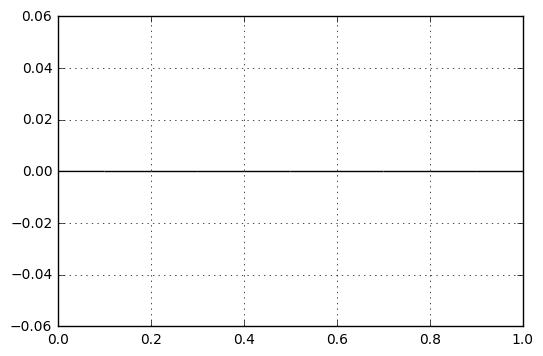

In [9]:
pd.Series([article['matches'][0] for article in data if 'matches' in article and article['matches'][0] > 0]).hist()

In [14]:
# Number of articles with matches.
len([article for article in data if article['matches'][0] > 0])

891